In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [2]:
def extend_vector_with_weekday(hubs,sin,cos,sinh,cosh):
    l = []
    for hub in range(len(hubs)):
        h = list(hubs[hub])
        h.extend([sin[hub],cos[hub],sinh[hub],cosh[hub]])
        l.append(np.array(h))
    return l

In [3]:
data = pd.read_pickle('DR_Data/pickup_series_1_zone.pickle')
pickups_out = np.array(data.Hubs)
weekday = True
added_features = 0
if weekday:
    data.Hubs = extend_vector_with_weekday(data.Hubs,data.weekday_sin,data.weekday_cos,data.hour_sin,data.hour_cos,)
    added_features = added_features + 4
    
pickups_in = np.array(data.Hubs)

num_zones = pickups_in[0].shape[0] - added_features # -2 from weekdays sin and cos
seq_length = 28
num_intervals = pickups_in.shape[0]-seq_length
num_features = pickups_in[0].shape[0] 

X = np.zeros((num_features, seq_length, num_intervals))
y = np.zeros((num_zones, 1, num_intervals))
for i in range(num_intervals):
    X[:,:,i] = np.array(list(pickups_in[i:i+seq_length])).T
    y[:,:,i] = np.array([pickups_out[i+seq_length]]).T
    
print(X.shape,y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X.transpose(), y.transpose(), test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)

(5, 28, 1551) (1, 1, 1551)
(1240, 28, 5) (1240, 1, 1)


In [4]:
np.array(list(pickups_in[i:i+4]))

array([[ 2.    ,  0.7818,  0.6235,  0.    , -1.    ],
       [ 0.    ,  0.7818,  0.6235, -1.    , -0.    ],
       [ 0.    ,  0.9749, -0.2225,  0.    ,  1.    ],
       [ 1.    ,  0.9749, -0.2225,  1.    ,  0.    ]])

In [5]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [6]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
use_cuda =False

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [7]:
rnn_seq_length = seq_length
rnn_input_size = num_features
rnn_hidden_size = 6
rnn_direction = 0

rnn_out_features = rnn_seq_length*rnn_hidden_size*(rnn_direction+1)
features_cat_size = rnn_out_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.drop = Dropout(p=0.5)
        self.bn0 = BatchNorm1d(rnn_seq_length)
        
        self.rnn_1 = nn.LSTM(input_size=rnn_input_size,
                            hidden_size=rnn_hidden_size,
                            num_layers=1,
                            bidirectional=(rnn_direction>0))
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=num_zones,
                            bias=True)
        
    def forward(self, x):
        features = []
        out = {}
        #x = self.bn0(x)
        
        features_rnn = x.view(rnn_seq_length, -1, rnn_input_size)
        features_rnn,_ = self.rnn_1(features_rnn)
        features_rnn = self.drop(features_rnn)
        
        features_rnn = features_rnn.view(-1, rnn_out_features) #self.rnn_1.hidden_size)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        
        #features_final = self.drop(features_final)
        out['out'] = self.l_out(features_final)
        '''
        x, (h,c) = self.rnn_1(x)
        #x = x.view(-1,self.rnn_1.rnn_hidden_size)
        x = self.l_out(x)
        return x
        '''
        return out['out']

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (bn0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_1): LSTM(5, 6)
  (l_out): Linear(in_features=168, out_features=1, bias=True)
)


Epoch 0 	 train loss: 10.3279214848 	 valid loss: 16.1118851162 	 valid acc: 0.4148
Epoch 5 	 train loss: 6.1442120633 	 valid loss: 5.2977477425 	 valid acc: 0.2605
Epoch 10 	 train loss: 5.9349776370 	 valid loss: 5.0054810944 	 valid acc: 0.2669
Epoch 15 	 train loss: 5.7905872968 	 valid loss: 4.9223572302 	 valid acc: 0.2926
Epoch 20 	 train loss: 5.4930198677 	 valid loss: 4.8991278736 	 valid acc: 0.2990
Epoch 25 	 train loss: 5.5469513880 	 valid loss: 4.7959218028 	 valid acc: 0.2958
Epoch 30 	 train loss: 5.4889745554 	 valid loss: 4.8418514758 	 valid acc: 0.3023
Epoch 35 	 train loss: 5.4870645896 	 valid loss: 4.7802279155 	 valid acc: 0.3248
Epoch 40 	 train loss: 5.4126345431 	 valid loss: 4.7867604118 	 valid acc: 0.3248
Epoch 45 	 train loss: 5.3856354863 	 valid loss: 4.6493839832 	 valid acc: 0.3215
Epoch 50 	 train loss: 5.0666014638 	 valid loss: 4.7167623300 	 valid acc: 0.2958


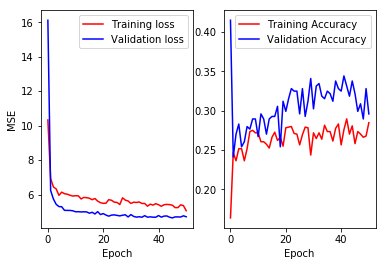

In [8]:
# Hyper-parameters
num_epochs = 51

# Define a loss function and optimizer for this problem
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3)

def accuracy(ys, ts):
    predictions = torch.round(ys)
    correct_prediction = torch.eq(predictions,ts)
    return torch.mean(correct_prediction.float())

# Track loss
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_training_accs = 0
    epoch_validation_loss = 0
    epoch_validation_accs = 0
    
    net.eval()
    for j in range(X_valid.shape[0]):
        inputs = get_variable(torch.Tensor(X_valid[j]))
        targets = get_variable(torch.Tensor(y_valid[j]))
        # Forward pass
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
        epoch_validation_accs += accuracy(outputs, targets)
    
    net.train()
    for j in range(X_train.shape[0]):
        inputs = get_variable(torch.Tensor(X_train[j]))
        targets = get_variable(torch.Tensor(y_train[j]))
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        epoch_training_accs += accuracy(outputs,targets)
        
    # Save loss for plot
    train_loss.append(epoch_training_loss/X_train.shape[0])
    train_accs.append(epoch_training_accs/X_train.shape[0])
    valid_loss.append(epoch_validation_loss/X_valid.shape[0])
    valid_accs.append(epoch_validation_accs/X_valid.shape[0])

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i} \t train loss: {train_loss[-1]:.10f} \t valid loss: {valid_loss[-1]:.10f} \t valid acc: {valid_accs[-1]:.4f}')



# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.subplot(1,2,1)
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(epoch, train_accs, 'r', label='Training Accuracy')
plt.plot(epoch, valid_accs, 'b', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('')
plt.show()

In [9]:
outputs

tensor([[4.6448]], grad_fn=<AddmmBackward>)

In [10]:
targets

tensor([[2.]])

In [11]:
outputs-targets

tensor([[2.6448]], grad_fn=<SubBackward0>)